In [78]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d
from scipy.stats import landau

FADC_BIN_WIDTH = 1


In [79]:
def load_pmt(input_file,pmtname, minnpe = 0., top_bottom_coinc = False):
    pmt_bottom_condition = "pmt4 >= 0"
    if(top_bottom_coinc): pmt_bottom_condition = "pmt4 >= 10" 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    query_string_em = pmt_bottom_condition + " and (id == 1 or id == 2 or id == -2)"
    query_string_mu = pmt_bottom_condition + "and (id == 3 or id == -3)"
 
    pmt_em = data.query(query_string_em)[pmtname]
    pmt_mu = data.query(query_string_mu)[pmtname]

    pmt_mu = np.asarray(pmt_mu[pmt_mu >= minnpe])
    pmt_em = np.asarray(pmt_em[pmt_em >= minnpe])
    pmt_tot = np.concatenate((pmt_mu,pmt_em))
    
    return pmt_em, pmt_mu, pmt_tot

def load_top_sum_fadc_pmt(input_file, minnpe = 0., top_bottom_coinc = False): 
    pmt_bottom_condition = "pmt4 >= 0 "
    if(top_bottom_coinc): pmt_bottom_condition = "pmt4 >= 10" 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    query_string_em = pmt_bottom_condition + " and (id == 1 or id == 2 or id == -2)"
    query_string_mu = pmt_bottom_condition + "and (id == 3 or id == -3)"
    pmt_em_1 = data.query(query_string_em)['pmt1_FADC']
    pmt_mu_1 = data.query(query_string_mu)['pmt1_FADC']
    pmt_em_2 = data.query(query_string_em)['pmt2_FADC']
    pmt_mu_2 = data.query(query_string_mu)['pmt2_FADC']
    pmt_em_3 = data.query(query_string_em)['pmt3_FADC']
    pmt_mu_3 = data.query(query_string_mu)['pmt3_FADC']

    pmt_mu_1 = np.asarray(pmt_mu_1[pmt_mu_1 >= minnpe])
    pmt_em_1 = np.asarray(pmt_em_1[pmt_em_1 >= minnpe])
    pmt_tot_1 = np.concatenate((pmt_mu_1,pmt_em_1))

    pmt_mu_2 = np.asarray(pmt_mu_2[pmt_mu_2 >= minnpe])
    pmt_em_2 = np.asarray(pmt_em_2[pmt_em_2 >= minnpe])
    pmt_tot_2 = np.concatenate((pmt_mu_2,pmt_em_2))

    pmt_mu_3 = np.asarray(pmt_mu_3[pmt_mu_3 >= minnpe])
    pmt_em_3 = np.asarray(pmt_em_3[pmt_em_3 >= minnpe])
    pmt_tot_3 = np.concatenate((pmt_mu_3,pmt_em_3))

    pmt_tot = np.concatenate((pmt_tot_1, pmt_tot_2, pmt_tot_3))
    
    return pmt_tot

In [80]:

# Gaussian function for fitting
def gaussian(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def landau_func(x, A, mu, sigma): 
    return A * landau.pdf(x,mu,sigma)

def pol_2(x, p0, p1, p2): 
    return p0 * x * x + p1 * x + p2 


# Define funciton to perform Gaussian fit of the peak 
fadc_bins = np.arange(0,1000,1)

def gaussian_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('FADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins)
    sigma_entries_fit = np.sqrt(entries_fit)
    sigma_entries_fit[sigma_entries_fit == 0] = 1e-6  # avoid zero division

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for Gaussian parameters 
    p0 = [max(array_to_fit), np.mean(array_to_fit), 2.5*np.std(array_to_fit)]
    print('\nFirst guess ',p0)
    bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])

    #array_to_fit = input_array[(input_array > 1.5*np.std(array_to_fit)) & (input_array < 2.5*np.std(array_to_fit))]

    #popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0, bounds = bounds, sigma = sigma_entries_fit, absolute_sigma=True)
    popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0)

    # Extract parameter estimates
    A_fit, mu_fit, sigma_fit = popt

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))
    A_err, mu_err, sigma_err = perr


    return popt, perr, range 


def pol2_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('\nFADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    fadc_bins_fit = np.arange(fadc_low, fadc_hi+1, FADC_BIN_WIDTH )

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins_fit)

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for pol2 parameters 
    p0 = np.polyfit(bin_centers, entries_fit, deg=2)
    print('First guess ',p0)

    popt, pcov = curve_fit(pol_2, bin_centers, entries_fit, p0=p0)

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))

    #popt = p0

    return popt, perr, range 

In [81]:
# Function to find minumum in a range defined by a lower limit and the peak maximum 

def find_valley(input_array, low_threshold, peak_position): 
    print('Looking for minimum between ',low_threshold,' and ', peak_position)
    array_formin = input_array[(input_array >low_threshold) & (input_array < peak_position)]

    bins = np.arange(low_threshold+2, int(peak_position),FADC_BIN_WIDTH)

    entries, bin = np.histogram(array_formin, bins=bins)
    fadc_min = np.argmin(entries)
    return bin[fadc_min]


Text(0, 0.5, 'Entries')

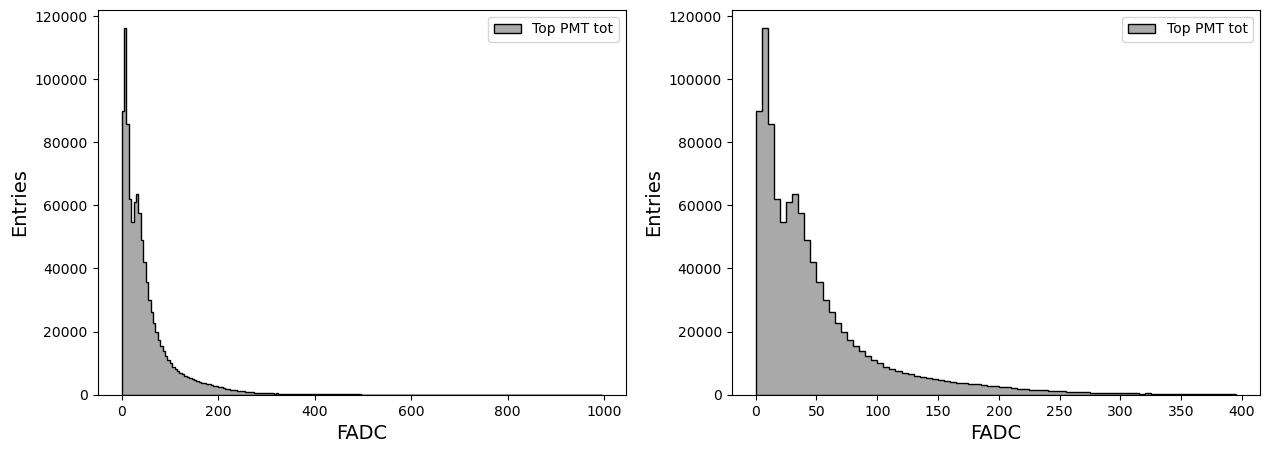

In [82]:
input_folder = '/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/t2b_simu/'
#input_files = ['top_30cm_0.50_3', 'top_35cm_0.50_3', 'top_40cm_0.50_3', 'top_45cm_0.50_3', 'top_50cm_0.50_3', 'top_55cm_0.50_3', 'top_60cm_0.50_3', 'top_65cm_0.50_3','top_70cm_0.50_3']
input_files = ['top_30cm_3', 'top_35cm_3', 'top_40cm_3', 'top_45cm_3', 'top_50cm_3', 'top_55cm_3', 'top_60cm_3', 'top_65cm_3','top_70cm_3']

min_npe = 5.
coinc = True 

plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
fadc_bins = np.arange(0,1000,5)

pmt_tot = load_top_sum_fadc_pmt(input_folder+input_files[3])
#pmt_tot = load_pmt(input_folder+input_files[3],'pmt4_FADC',min_npe)[2]
plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.legend()
plt.yscale('linear')
plt.xlabel('FADC',size=14)
plt.ylabel('Entries',size=14)


plt.subplot(1,2,2)
fadc_bins = np.arange(0,400,5)

plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.legend()
plt.yscale('linear')
plt.xlabel('FADC',size=14)
plt.ylabel('Entries',size=14)



FADC bin with largest entries  15
First guess  [  -156.33946078   4829.29215686 -20917.278125  ]
Result of Gaussian fit
p0 = -156.33946078431373  +- 8.919920176858623
p1 = 4829.292156862746  +- 234.78205826181312
p2 = -20917.278124999975  +- 1411.1038238186052
Peak position is:  15.444891944220176
Peak width is :  14.474163932928835
Looking for minimum between  5  and  15.444891944220176
Found minimum at  7 

Width at peak minimum:  15.781791434875398 


FADC bin with largest entries  20
First guess  [  -108.39233193   4533.31953782 -34046.48658088]
Result of Gaussian fit
p0 = -108.39233214083849  +- 8.93193048348022
p1 = 4533.3195450990725  +- 323.62690533844705
p2 = -34046.486640158815  +- 2788.390208063513
Peak position is:  20.911624722719083
Peak width is :  15.696614270060818
Looking for minimum between  5  and  20.911624722719083
Found minimum at  7 

Width at peak minimum:  18.62696237932561 


FADC bin with largest entries  26
First guess  [   -88.81003555   4733.55381383 -51

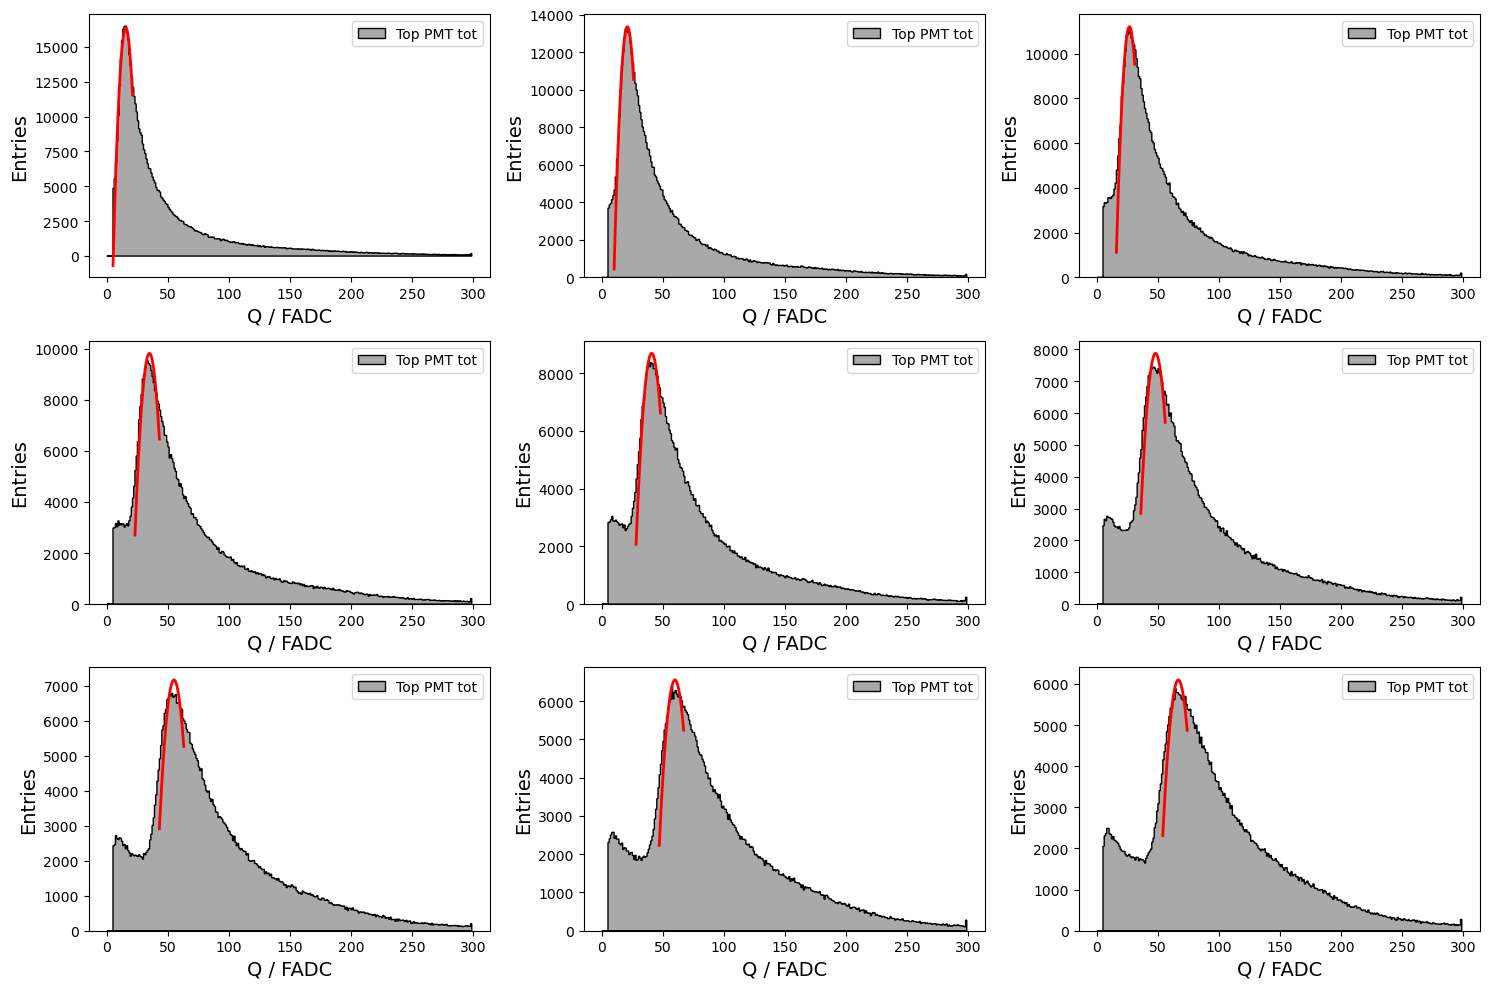

In [83]:
plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,300,FADC_BIN_WIDTH)
fadc_bin_centers = (fadc_bins_fit[:-1] + fadc_bins_fit[1:]) / 2.

low_count_threshold_array = [5, 5, 5, 10, 10, 10, 20, 20, 20]
low_count_threshold_array_min = [5, 5, 5, 10, 10, 10, 20, 20, 20]
#low_count_threshold_array_min = [10, 20, 20, 30, 30, 50, 50, 50, 50]
range_width_low = [10, 10, 10, 10, 10, 10, 10, 10, 10]
range_width_hi = [6, 6, 5, 10, 10, 10, 10, 10, 10]

fadc_peak_bin = np.zeros(len(input_files))
rel_peak_err = np.zeros(len(input_files))
fadc_peak_entries = np.zeros(len(input_files))
fadc_peak_width = np.zeros(len(input_files))

fadc_peak_pos = np.zeros(len(input_files))

fadc_min_bin = np.zeros(len(input_files))
fadc_min_entries = np.zeros(len(input_files))

coinc = True 
min_npe_th = 5


for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_top_sum_fadc_pmt(input_folder+file, minnpe=min_npe_th, top_bottom_coinc=coinc)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    par, d_par, range = pol2_fit(pmt_tot, fadc_bins_fit, range_low=range_width_low[i], range_hi=range_width_hi[i], low_count_threshold=low_count_threshold_array[i])
    p0_fit, p1_fit, p2_fit = par
    p0_err, p1_err, p2_err = d_par

    # Compute fitted curve
    x_fit = np.linspace(range[0], range[1], 1000)
    y_fit = pol_2(x_fit, *par)

    print('Result of Gaussian fit')

    p0_err, p1_err, p2_err = d_par
    print('p0 =',p0_fit,' +-',p0_err)
    print('p1 =',p1_fit,' +-',p1_err)
    print('p2 =',p2_fit,' +-',p2_err)

    peak_parabola = -0.5 * par[1] / par[0]
    fadc_peak_pos[i] = peak_parabola
    print('Peak position is: ',peak_parabola)

    d_peak_parabola_rel = np.sqrt( (d_par[1]/par[1])**2 + (d_par[0]/par[0])**2 )
    #rel_peak_err[i] = d_peak_parabola_rel

    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    #plt.plot(x_fit, y_fit, linewidth=2, label=f'Fit: μ={mu_fit:.2f}, σ={sigma_fit:.2f}',color='red')
    plt.plot(x_fit, y_fit, linewidth=2, color='red')
    plt.legend()
    plt.yscale('linear')
    plt.xlabel('Q / FADC',size=14)
    plt.ylabel('Entries',size=14)

    fadc_peak_bin[i] = np.digitize(peak_parabola, fadc_bins_fit) - 1
    fadc_peak_entries[i] = entries[np.digitize(peak_parabola, fadc_bins_fit) - 1]

    ymax = - par[1]**2/(4*par[0]) + par[2]

    a = par[0]
    b = par[1]
    c = par[2] - ymax / 2.

    fwhm = np.sqrt(b**2 - 4 * a * c) / np.abs(a) 

    print('Peak width is : ',fwhm)

    fadc_min = find_valley(pmt_tot, low_threshold=low_count_threshold_array_min[i], peak_position=peak_parabola)
    print('Found minimum at ',fadc_min,'\n')
    fadc_min_bin[i] = np.digitize(fadc_min, fadc_bins_fit) - 1
    fadc_min_entries[i] = entries[np.digitize(fadc_min, fadc_bins_fit) -1]
    rel_peak_err[i] = np.sqrt( 1 / fadc_peak_entries[i] + 1 / fadc_min_entries[i] )

##
    c = par[2] - fadc_min_entries[i]
    w_min = np.sqrt(b**2 - 4 * a * c) / np.abs(a) 
##
    print('Width at peak minimum: ',w_min,'\n')
##
    fadc_peak_width[i] = w_min


plt.tight_layout()
#plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_fit_pol2_PE.pdf')


In [84]:
print(fadc_peak_bin)
print(fadc_peak_entries)

[15. 20. 26. 34. 40. 48. 54. 59. 66.]
[16483. 13291. 11032.  9426.  8364.  7334.  6665.  6228.  5784.]


Max coordinates ( 15.5 ,  16483.0 )
Max coordinates ( 20.5 ,  13291.0 )
Max coordinates ( 26.5 ,  11032.0 )
Max coordinates ( 34.5 ,  9426.0 )
Max coordinates ( 40.5 ,  8364.0 )
Max coordinates ( 48.5 ,  7334.0 )
Max coordinates ( 54.5 ,  6665.0 )
Max coordinates ( 59.5 ,  6228.0 )
Max coordinates ( 66.5 ,  5784.0 )


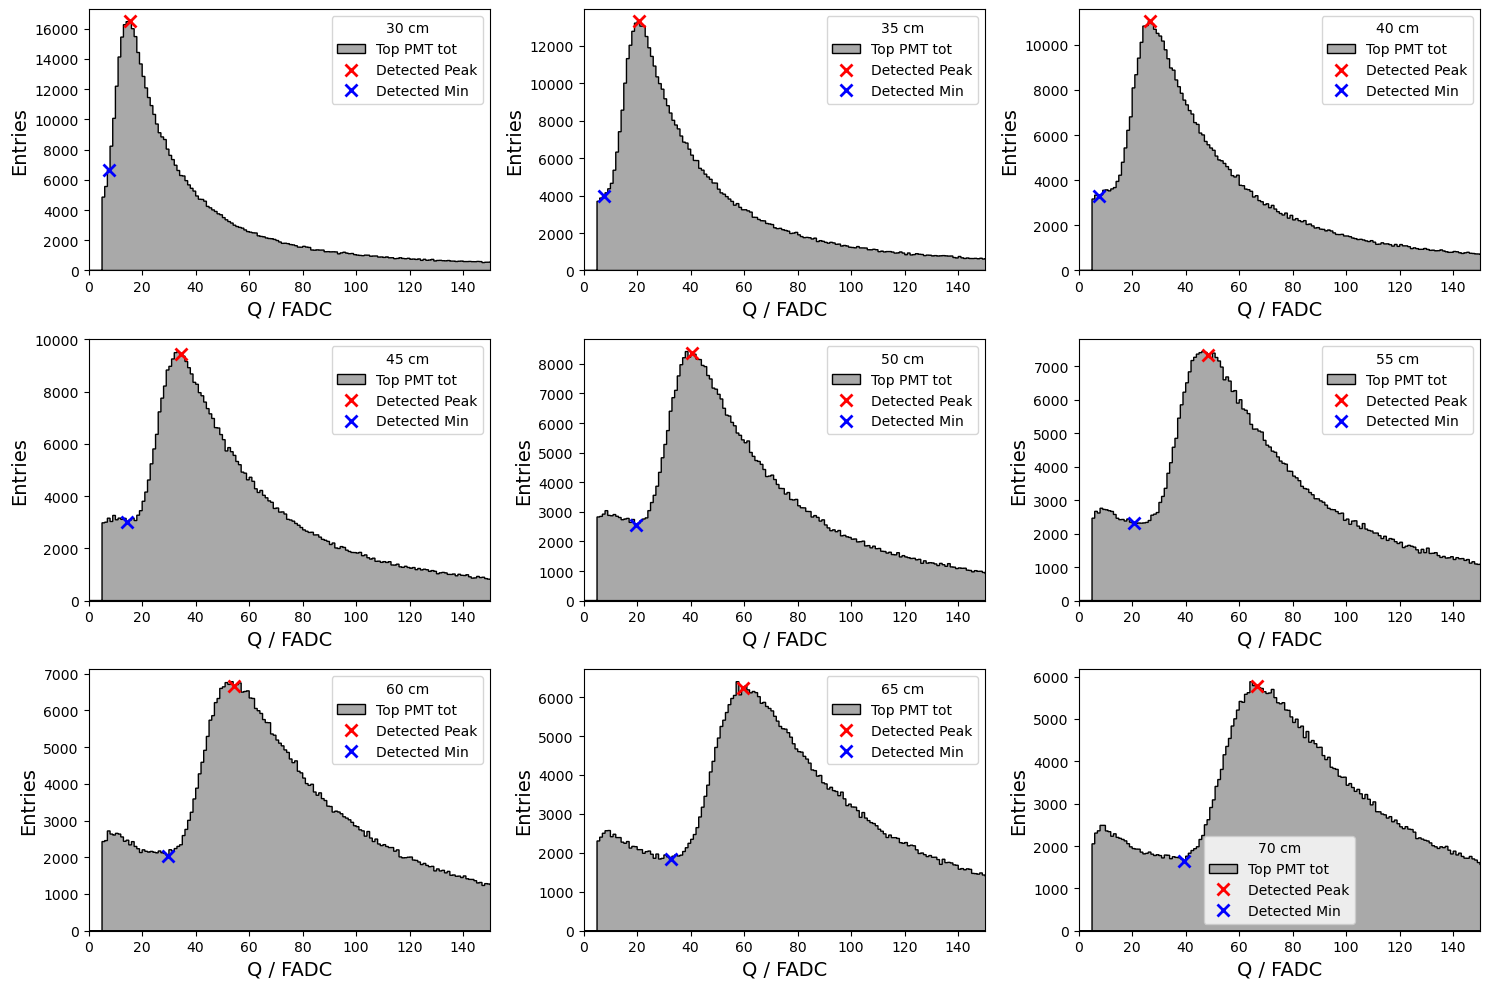

In [85]:
fig, axes = plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,600,FADC_BIN_WIDTH)

leg_title = ['30 cm','35 cm','40 cm','45 cm','50 cm','55 cm','60 cm','65 cm','70 cm']

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_top_sum_fadc_pmt(input_folder+file, minnpe=min_npe_th, top_bottom_coinc=coinc)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    i_peak_bin = int(fadc_peak_bin[i])
    i_min_bin = int(fadc_min_bin[i])

    print('Max coordinates (',fadc_bin_centers[i_peak_bin],', ',fadc_peak_entries[i],')')
    entries, bin, fig_i = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(fadc_bin_centers[i_peak_bin], fadc_peak_entries[i], 'rx', label='Detected Peak', ms=8, mew=2)
    plt.plot(fadc_bin_centers[i_min_bin], fadc_min_entries[i], 'bx', label='Detected Min',ms=8, mew=2)

    plt.legend(title = leg_title[i])
    plt.yscale('linear')
    plt.xlabel('Q / FADC',size=14)
    plt.ylabel('Entries',size=14)

    plt.xlim(0,150)

plt.tight_layout()

#plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_scan_max_min_pol2_PE.pdf')

Max coordinates ( 40.5 ,  8364.0 )


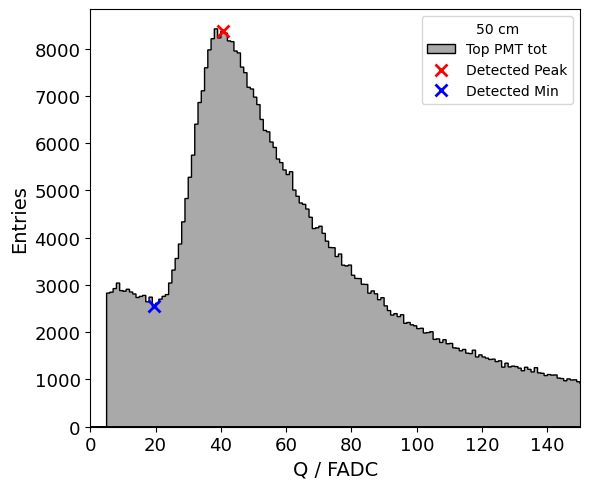

In [ ]:
plt.figure(figsize=(6,5))
fadc_bins_fit = np.arange(0,600,FADC_BIN_WIDTH)

i = 4 
pmt_tot = load_top_sum_fadc_pmt(input_folder+input_files[4], minnpe=min_npe_th, top_bottom_coinc=coinc)

i_peak_bin = int(fadc_peak_bin[i])
i_min_bin = int(fadc_min_bin[i])

print('Max coordinates (',fadc_bin_centers[i_peak_bin],', ',fadc_peak_entries[i],')')
plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.plot(fadc_bin_centers[i_peak_bin], fadc_peak_entries[i], 'rx', label='Detected Peak', ms=8, mew=2)
plt.plot(fadc_bin_centers[i_min_bin], fadc_min_entries[i], 'bx', label='Detected Min',ms=8, mew=2)

plt.legend(title = leg_title[i])
plt.yscale('linear')
plt.xlabel('Q / FADC',size=14)
plt.ylabel('Entries',size=14)

plt.xlim(0,150)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/peak_dip_FADC_50cm_coinc.pdf')


#plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_scan_max_min_pol2_PE.pdf')

[0.0145336  0.01812014 0.01979521 0.02091494 0.02262796 0.023859
 0.02528387 0.02653939 0.02794268]
[15.44489194 20.91162472 26.64988131 34.85658187 40.82236565 48.07097369
 54.98749069 59.88878824 66.74811769]


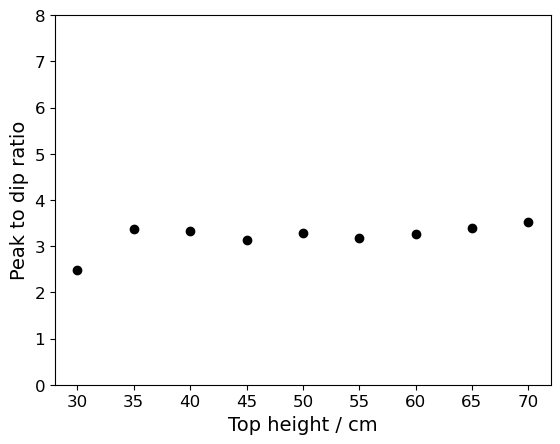

In [87]:
print(rel_peak_err)
top_height = np.arange(30,75,5)
ratio = fadc_peak_entries / fadc_min_entries
err = ratio * rel_peak_err
plt.errorbar(top_height, ratio, yerr = ratio * rel_peak_err, fmt='o',markerfacecolor='black', markeredgecolor='black', ecolor = 'black')
plt.xlabel('Top height / cm',size=14)
plt.ylabel('Peak to dip ratio',size=14)

#plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_scan_peak_dip_ratio_pol2_PE.pdf')

print(fadc_peak_pos)
plt.ylim(0,8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

np.save('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/calibration_arrays/top_PMT_peak_position_FADC_coinc.npy',fadc_peak_pos)

np.savez('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/calibration_arrays/peak_dip_ratio_coinc_FADC.npz', top_height=top_height[2:], ratio = ratio[2:], ratio_err = err[2:] )

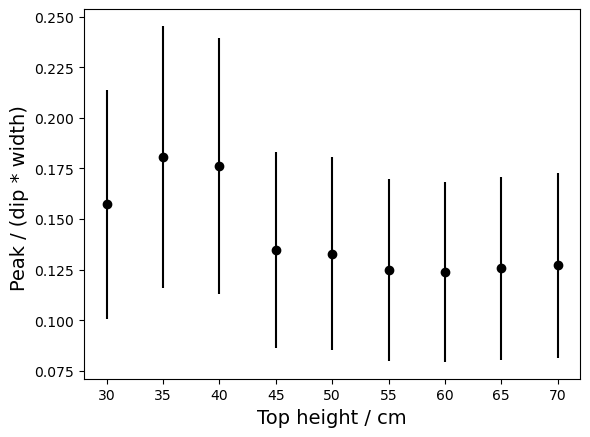

In [88]:
top_height = np.arange(30,75,5)
ratio_2 = fadc_peak_entries / (fadc_min_entries * (fadc_peak_width))
#ratio_2 = (fadc_peak_entries - fadc_min_entries) / (fadc_peak_width)

plt.errorbar(top_height, ratio_2, yerr = ratio_2 * d_peak_parabola_rel, fmt='o',markerfacecolor='black', markeredgecolor='black', ecolor = 'black')
plt.xlabel('Top height / cm',size=14)
plt.ylabel('Peak / (dip * width) ',size=14)

plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_scan_quality_par_pol2.pdf')